# 心电分类模型

In [1]:
# 导入模块
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_filepath = "../data/numpy_data/"

X_train = np.load(data_filepath + 'X_train.npy')
y_train = np.load(data_filepath + 'y_train.npy', allow_pickle=True)
X_test = np.load(data_filepath + 'X_test.npy')
y_test = np.load(data_filepath + 'y_test.npy', allow_pickle=True)

# reshape y_train, y_test
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [3]:
def shuffle_train_test(X_train, y_train, X_test, y_test):
    shuffled_indices_x = np.random.permutation(len(y_train))
    shuffled_indices_y = np.random.permutation(len(y_test))

    return X_train[shuffled_indices_x], y_train[shuffled_indices_x], X_test[shuffled_indices_y], y_test[shuffled_indices_y]

In [4]:
# 打乱数据
X_train, y_train, X_test, y_test = shuffle_train_test(X_train, y_train, X_test, y_test)

## 查看数据并调整数据格式

### 查看输入x和标签的维度是否匹配

In [5]:
X_train.shape

(16966, 500, 12)

In [6]:
y_train.shape

(16966, 1)

In [7]:
X_test.shape

(1901, 500, 12)

y_test.shape

### 将y映射为数组

In [8]:
num2class = np.array(['NORM', 'MI', 'STTC', 'CD', 'HYP'])

In [9]:
np.where(num2class == 'STTC')[0][0]

2

In [10]:
for index in range(len(y_train)):
    y_train[index] = np.where(num2class == y_train[index][0][0])[0]

In [11]:
for index in range(len(y_test)):
    y_test[index] = np.where(num2class == y_test[index][0][0])[0]

In [12]:
y_train = y_train.reshape(1, -1)[0].astype('uint8')
y_test = y_test.reshape(1, -1)[0].astype('uint8')

In [13]:
y_test

array([3, 0, 0, ..., 4, 1, 0], dtype=uint8)

## 数据集过采样

这里的心电数据样本存在样本不均衡的问题，所有的分类中正样本比例均显著低于负样本比例，如果采用欠采样的话会使训练集丢失部分数据，而过采样会导致一个数据点在高维空间出现多次，增加过拟合风险，很多研究通过在过采样中加入少量随机噪声来减少这类风险

这里需要安装`imblearn`包，使用以下的命令行安装

```shell
pip install imbalanced-learn
```

In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
oversampler = SMOTE(random_state=42)

os_features, os_label = oversampler.fit_sample(X_train.reshape(len(X_train), 6000), y_train)

In [16]:
os_features.shape

(36080, 6000)

In [17]:
os_label.shape

(36080,)

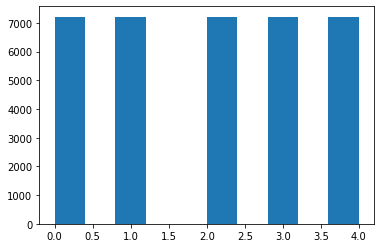

In [18]:
# 查看数据分布
plt.figure()
plt.hist(os_label)
plt.show()

## PCA降维

In [19]:
from sklearn.decomposition import PCA

### 训练集PCA降维

In [20]:
pca_train = PCA(n_components=240)
pca_train.fit(os_features)

PCA(n_components=240)

In [21]:
X_train_pca = pca_train.fit_transform(os_features)

In [22]:
pca_train.explained_variance_ratio_.sum()

0.9908215246322652

In [23]:
X_train_pca.shape

(36080, 240)

### 测试集PCA降维

In [24]:
X_test_flatten = X_test.reshape(len(X_test), 6000)
pca_test = PCA(n_components=240)
pca_test = PCA(X_test_flatten)

In [25]:
X_test_pca = pca_train.fit_transform(X_test_flatten)

In [26]:
X_test_pca.shape

(1901, 240)

## 训练模型 

In [131]:
train_class = 2
print("---train class is %s---"%(num2class[train_class]))
y_train_norm = (os_label == train_class)
y_test_norm = (y_test == train_class)

# y_train_mi = (os_label == 1).reshape(1, -1)[0]
# y_test_mi = (y_test == 1).reshape(1, -1)[0]

# y_train_sttc = (os_label == 2).reshape(1, -1)[0]
# y_test_sttc = (y_test == 2).reshape(1, -1)[0]

# y_train_cd = (os_label == 3).reshape(1, -1)[0]
# y_test_cd = (y_test == 3).reshape(1, -1)[0]

# y_train_hyp = (os_label == 4).reshape(1, -1)[0]
# y_test_hyp = (y_test == 4).reshape(1, -1)[0]

---train class is STTC---


### 二分类模型

In [132]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [133]:
# sgd_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("sgd_clf", SGDClassifier(random_state=42))
# ])
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_pca, y_train_norm)

SGDClassifier(random_state=42)

In [134]:
y_predict_sgd = sgd_clf.predict(X_test_pca)
y_predict_sgd[0:10]

array([False, False, False, False, False, False,  True, False, False,
       False])

In [135]:
y_test_norm[0:10]

array([False, False, False, False, False, False,  True,  True, False,
       False])

#### K折交叉验证

In [136]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def k_fold_val(classifier, k_fold=5):
    skfolds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    fold = 1
    total_accu = 0
    for train_index, test_index in skfolds.split(X_train_pca, y_train_norm):
        clone_clf = clone(classifier)
        X_train_folds = X_train_pca[train_index]
        y_train_folds = y_train_norm[train_index]
        X_test_fold = X_train_pca[test_index]
        y_test_fold = y_train_norm[test_index]
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print("Fold %d accuracy: %f"%(fold, n_correct / len(y_pred)))
        fold += 1
        total_accu += n_correct / len(y_pred)
    print("\nTotal Accuracy: %f" % (total_accu/k_fold))


In [137]:
k_fold_val(sgd_clf)

Fold 1 accuracy: 0.783814
Fold 2 accuracy: 0.784091
Fold 3 accuracy: 0.778686
Fold 4 accuracy: 0.777578
Fold 5 accuracy: 0.789911

Total Accuracy: 0.782816


In [138]:
from sklearn.model_selection import cross_val_score

In [139]:
cross_val_score(sgd_clf, X_train_pca, y_train_norm, cv=5, scoring="accuracy")

array([0.78187361, 0.78395233, 0.78727827, 0.77896341, 0.62444568])

#### 查看混淆矩阵

In [140]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score

In [141]:
y_train_pred_sgd = cross_val_predict(sgd_clf, X_train_pca, y_train_norm, cv=5)
confusion_matrix(y_train_norm, y_train_pred_sgd)

array([[26350,  2514],
       [ 6459,   757]])

In [142]:
precision_score(y_train_norm, y_train_pred_sgd)

0.23142769795169674

In [143]:
recall_score(y_train_norm, y_train_pred_sgd)

0.10490576496674058

In [144]:
f1_score(y_train_norm, y_train_pred_sgd)

0.1443692190330886

#### ROC曲线

In [145]:
from sklearn.metrics import roc_curve

y_scores_sgd = cross_val_predict(sgd_clf, X_train_pca, y_train_norm, cv=5,
method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_norm, y_scores_sgd)

In [146]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

In [148]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_norm, y_scores_norm)

0.45509206759369425

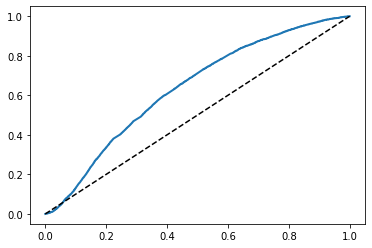

In [147]:
plot_roc_curve(fpr, tpr)
plt.show()

### 随机森林模型

In [159]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train_pca, y_train_norm, cv=5 ,method="predict_proba")

In [160]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_norm, y_scores_forest)

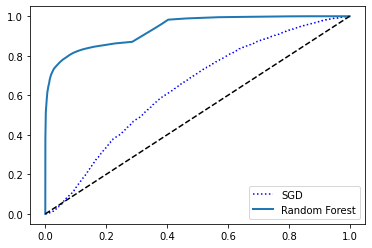

In [161]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [162]:
roc_auc_score(y_train_norm, y_scores_forest)

0.9360270494767724

In [163]:
y_train_pred = (y_scores_forest>=0.5)

In [164]:
confusion_matrix(y_train_norm, y_train_pred)

array([[28814,    50],
       [ 3491,  3725]])

In [165]:
precision_score(y_train_norm, y_train_pred)

0.9867549668874173

In [166]:
recall_score(y_train_norm, y_train_pred)

0.5162139689578714

In [167]:
f1_score(y_train_norm, y_train_pred)

0.6778273132563005

In [207]:

y_scores_forest_all = []
for train_class in range(1,5):
    print("----training classifier for %s----"%(num2class[train_class]))
    y_train_norm = (os_label == train_class)

    forest_clf = RandomForestClassifier(random_state=42)
    y_probas_forest = cross_val_predict(forest_clf, X_train_pca, y_train_norm, cv=5 ,method="predict_proba")
    y_scores_forest = y_probas_forest[:, 1]
    y_train_pred = (y_scores_forest>=0.5)
    y_scores_forest_all.append(y_scores_forest)

    print("accuracy: %.3f" % np.mean(cross_val_score(forest_clf, X_train_pca, y_train_norm, cv=5, scoring="accuracy")))
    print("precision: %.3f" % precision_score(y_train_norm, y_train_pred))
    print("recall: %.3f" % recall_score(y_train_norm, y_train_pred))
    print("f1-score: %.3f" % f1_score(y_train_norm, y_train_pred))
    print("roc score: %.3f" % roc_auc_score(y_train_norm, y_scores_forest))

----training classifier for MI----
accuracy: 0.904
precision: 0.993
recall: 0.535
f1-score: 0.695
roc score: 0.950
----training classifier for STTC----
accuracy: 0.899
precision: 0.987
recall: 0.516
f1-score: 0.678
roc score: 0.936
----training classifier for CD----
accuracy: 0.905
precision: 0.911
recall: 0.587
f1-score: 0.714
roc score: 0.914
----training classifier for HYP----
accuracy: 0.940
precision: 0.990
recall: 0.720
f1-score: 0.833
roc score: 0.963


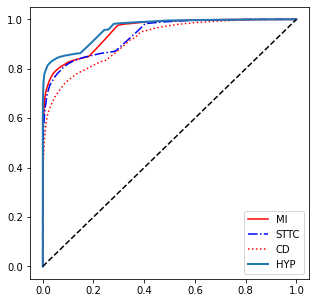

In [224]:
line = ["","r-", "b-.", "r:", "b--"]
plt.figure()
plt.rcParams['figure.figsize'] = (5.0, 5.0)

for i in range(3):

    y_train_norm = (os_label == i + 1)
    fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_norm, y_scores_forest_all[i])

    plt.plot(fpr_forest, tpr_forest, line[i+1], label=num2class[i+1])

y_train_norm = (os_label == 4)
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_norm, y_scores_forest_all[3])
plot_roc_curve(fpr_forest, tpr_forest, "HYP")
plt.legend(loc="lower right")